In [1]:
# Compute the average colour histogram for each of the RGB Colour channels
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
%matplotlib inline

path_to_image_buoy1 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy1\\train\\buoy156.png'
path_to_image_buoy2 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy2\\train\\buoy108.png'
path_to_image_buoy3 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy3\\train\\buoy28.png'
img1 = cv2.imread(path_to_image_buoy1)
img2 = cv2.imread(path_to_image_buoy2)
img3 = cv2.imread(path_to_image_buoy3)
cv2.imshow('img1',img1)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [28]:
# initialise step of em algorithm
def initialise_step(n, d, k):
    
    """
    Inputs:
    n - number of datapoints
    d - dimension of the gaussian
    k - number of the gaussians
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    probability_values - probability of the datapoint being in the k-gaussians, size (n x k)
    """
        
    # initialise weights
    weights_gaussian = np.zeros(k)
    for index in range(0, k):
        weights_gaussian[index] = (1.0 / k)
    
    # initialise mean
    mean_gaussian = np.zeros((k, d))
    
    # initialise covariance
    covariance_matrix_gaussian = np.zeros((k, d, d))
    
    # randomly initialise probability
    probability_values = np.zeros((n, k))
    for index in range(0, n):
        probability_values[index][np.random.randint(0, k)] = 1
        
    # return the arrays
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)

# Fit a gaussian using the datapoints obtained using the histogram
def fit_gaussian(image):
    
    color = ('b' , 'g' , 'r') # The number of color channels
    
    for i, col in enumerate(color):
        
        # Calculate the histogram for the Red Green and Blue color channel
        # If input is grayscale the channels = [0] but for color image the channels can be [0], [1], [2]
        histr = cv2.calcHist([image],[i],None,[256],[0,256])

        (mu , sigma) = norm.fit(histr) # Maximum likelihood estimate
        bins = np.linspace(0,255,256)
        print("mu:" + str(mu) + "sigma:" + str(sigma))
        plt.subplot(1,2,1)
        plt.plot(bins, norm.pdf(bins,mu,(sigma)),color=col); plt.xlim([0,256])
        plt.subplot(1,2,2)
        plt.plot(histr,color = col); plt.xlim([0,256])
    plt.show()

# gaussian estimation for expectation step
def gaussian_estimation(data_point, mean, covariance, dimension):
    """
    Inputs:
    data_point - data point of the gaussian, size (1 x d)
    mean - mean of the gaussian, size (1 x d)
    covariance - covariance of the gaussian, size (1 x d x d)
    dimension - dimension of the gaussian
    
    Outputs:
    value of the gaussian
    """
    
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1.0 / np.power((2 * np.pi), (dimension / 2))
    data_mean_diff = (data_point - mean)
    data_mean_diff_transpose = data_mean_diff.T     
    return (gaussian_pi_coeff) * (determinant_covariance_root) * np.exp(-0.5 * np.matmul(np.matmul(data_mean_diff, covariance_inverse), data_mean_diff_transpose))

# Perform the expectation step
def expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian):
    """
    Inputs:
    n - the number of data-points
    d - dimension of gaussian
    k - number of gaussians
    data - data to be trained on of size (n x d)
    weights_gaussian - weight of gaussians of size (k)
    mean_gaussian - mean of gaussians of size (k x d)
    covariance_matrix_gaussian - covariance of gaussians of size (k x d x d)
    probability_values - probability of the datapoint being in a gaussian of size (n x k)
    
    Outputs:
    probabilities - probability array of size (n x k)
    """
    
    # create empty array of list of probabilities
    probabilities = []
    
    # iterate through each item
    for j in range(0, n):
        
        # calculate probability of a point being in the k-gaussians
        probability_x = 0.0
        for i in range(0, k):
            probability_x = probability_x + gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]
        probability_x_temp = []    
        for i in range(0, k):
            val = (gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]) / probability_x
            probability_x_temp.append(val)
        
        # append probabilities of a point being in k-gaussians of size (1 x k)
        probabilities.append(probability_x_temp)
    return np.array(probabilities)


# The maximization step will compute the mean, the mixture prior and the Covariance for each of the gaussian"
def maximization_gaussian(data_probabilities, input_data, initial_mixture_coeff, initial_mean_gaussian, initial_covariance_gaussian):
    """
    K: Number of components of the gaussian mixture
    input_data: (NxD) which is number of datapoints times the dimension of each data point
    phi_k: List of mixture coefficients of size K
    mean_k: List of mean for the kth component of the Gaussian Mixture of the size (Kxd)
    sigma_square_k: Variance of the kth component of the mixture model (Kxdxd)
    data_probabilities: Probability of the ith datapoint coming from gaussian k. The size of this matrix is (nxk)
    
    """
    # Initializations for mixture coefficients, mean and covariance of the gaussian
    
    phi_k = initial_mixture_coeff
    mean_k = initial_mean_gaussian
    covariance = initial_covariance_gaussian
    
    # Number of Gaussians
    K = data_probabilities.shape[1]
    
    # Calculation for mixture model coefficients phi_k"
    phi_k = np.mean(data_probabilities, axis = 0)
    
    # Calculation of the mean for each k gaussian
    mean_k = np.matmul(data_probabilities.T, input_data) / np.sum(data_probabilities, axis = 0)[:,np.newaxis]
    
    #Calculation of the Variance for each kth Gaussian Distribution
    
    # Loop over each Gaussian
    for k in range(K):
        
        # Compute the difference of the ith data point with the kth gaussian mean
        x = input_data - mean_k[k,:]
        
        # Compute the transpose
        x_transpose = x.T
        
        # Convert the kth column of the probability matrix into a sparse diagonal matrix
        probability_diag = np.diag(data_probabilities[:,k])
        covariance_numerator = np.matmul(np.matmul(probability_diag, x) , x_transpose)
        
        # The covariance numerator is again a diagonal matrix whose elements we need to sum
        # k = 0 signifies take the main diagonal
        covariance_numerator = np.sum(np.diag(covariance_numerator,k=0))
        
        # Compute the covariance
        covariance[k,:,:] = covariance_numerator /  np.sum(data_probabilities,axis=0)[:,np.newaxis][k]
    
    return phi_k , mean_k , covariance

# run e-m algorithm
def run_expectation_maximization_algorithm(n, d, k, iterations, data):
    """
    Inputs:
    n - number of data-points
    d - dimension of gaussian
    k - number of gaussians
    iterations - number of iterations 
    data - training data, size (n x d)
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    """
    
    # initialise step
    (mixture_coeffs, mean_gaussian, covariance_matrix_gaussian, probability_values) = initialise_step(n, d, k)
    
    # run for fixed iterations
    for i in range(0, iterations):
        
        # m-step
        (weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = maximization_gaussian(probability_values,data,mixture_coeffs,mean_gaussian,covariance_matrix_gaussian)
        
        # e-step
        probability_values = expectation_step(n, d, k, data, mixture_coeffs, mean_gaussian, covariance_matrix_gaussian)
            
    # return answer
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian)

In [29]:
data = []
for row in range(img2.shape[0]):
    for col in range(img2.shape[1]):
        val = []
        val.append(img2[row, col, 2])
        data.append(val)
data = np.array(data)
data.shape

(2500, 1)

In [30]:
(weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = run_expectation_maximization_algorithm(2500, 1, 2, 50, data)

In [34]:
print(covariance_matrix_gaussian.shape)

(2, 1, 1)


In [35]:
y = []
x = []
for i in range(0, 256):
    x.append(i)
    output = gaussian_estimation(i, mean_gaussian[0], covariance_matrix_gaussian[0], 1) * weights_gaussian[0]
    y.append(output)

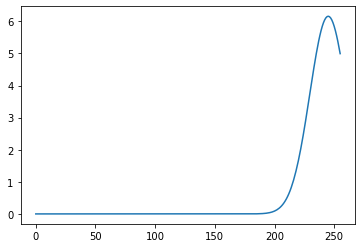

In [36]:
plt.plot(x, y)
plt.show()